In [ ]:
import numpy as np

test_data = np.load("/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/pickled_maps/map_2024_1_1_0_0_0.npy", allow_pickle=True)

In [ ]:
test_data

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test_data[0])

In [ ]:
test_data[0].shape

In [ ]:
np.std(test_data[0])

In [ ]:
import pandas as pd

stats_df = pd.read_csv(r"/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/npy_metrics.csv")

In [ ]:
stats_df['filename'].iloc[0]

In [ ]:
stats_df["timestamp_str"] = stats_df["filename"].str.extract(r"map_(\d+_\d+_\d+_\d+_\d+_\d+)\.npy")


In [ ]:
stats_df["datetime"] = pd.to_datetime(stats_df["timestamp_str"], format="%Y_%m_%d_%H_%M_%S")


In [ ]:
stats_df = stats_df.sort_values(by="datetime", ascending=True)

In [ ]:
(stats_df['mean']).mean(), stats_df['std'].mean()  # or better: use RMS of stds


stats_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

stats = ['std', 'max', 'min', 'mean']
# Plot
for value in stats:
    plt.figure(figsize=(12, 5))
    plt.plot(stats_df['datetime'], stats_df[f'{value}'], color='black')

    # Labels and formatting
    plt.xlabel("Year", fontsize=25)
    plt.ylabel(f"{value}", fontsize=25)
    plt.title(f"{value}", fontsize=25)
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.show()
    plt.tight_layout()
    plt.savefig(f"/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/plots/{value}.png")
    plt.close()


In [2]:
import sys
sys.path.append("/mnt/nas05/data01/francesco/progetto_simone/ionosphere")  # add current dir, where src/ is located

from src.data.dataset import IonoDataset

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.6.0+cu118)
    Python  3.10.16 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [ ]:
train_dataset = IonoDataset(
    path="/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/pickled_maps",
    transforms=True,
    split='train',
    seed=42
)

In [ ]:
train_dataset[0]

In [ ]:
import torch
torch.max(train_dataset[0][0]), torch.min(train_dataset[0][0]), torch.mean(train_dataset[0][0]), torch.std(train_dataset[0][0])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0][0].cpu().numpy())
plt.colorbar()

In [ ]:
from src.data.dataset import get_data_objects

train_dataset, train_sampler, train_data_loader = get_data_objects(
    path="/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/pickled_maps",
    batch_size=4,
    distributed=False,
    num_data_workers=1,
    split='train',
    seed=42
)

In [ ]:
train_dataset[0]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0][0].cpu().numpy())
plt.colorbar()

In [ ]:
import pandas as pd

df = pd.read_csv("/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv")

In [ ]:
df

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

features = df[["float1", "float2", "float3", "float4"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# cluster parameters
min_cluster = 2
max_cluster = 50
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, MeanShift

model = KMeans()
visualizer = KElbowVisualizer(model, k=(min_cluster, max_cluster + 1))
visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.show() 

In [4]:
# with optimal value of the elbo
from sklearn.cluster import KMeans
optimal_k = 3 #visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

In [7]:
df.to_csv("/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params_withcluster.csv", index=False)

In [4]:
import pandas as pd
df = pd.read_csv("/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params_withcluster.csv")

In [5]:
import numpy as np
np.unique(df['cluster'], return_counts=True)

(array([0, 1, 2]), array([100378,  82055,  80719]))

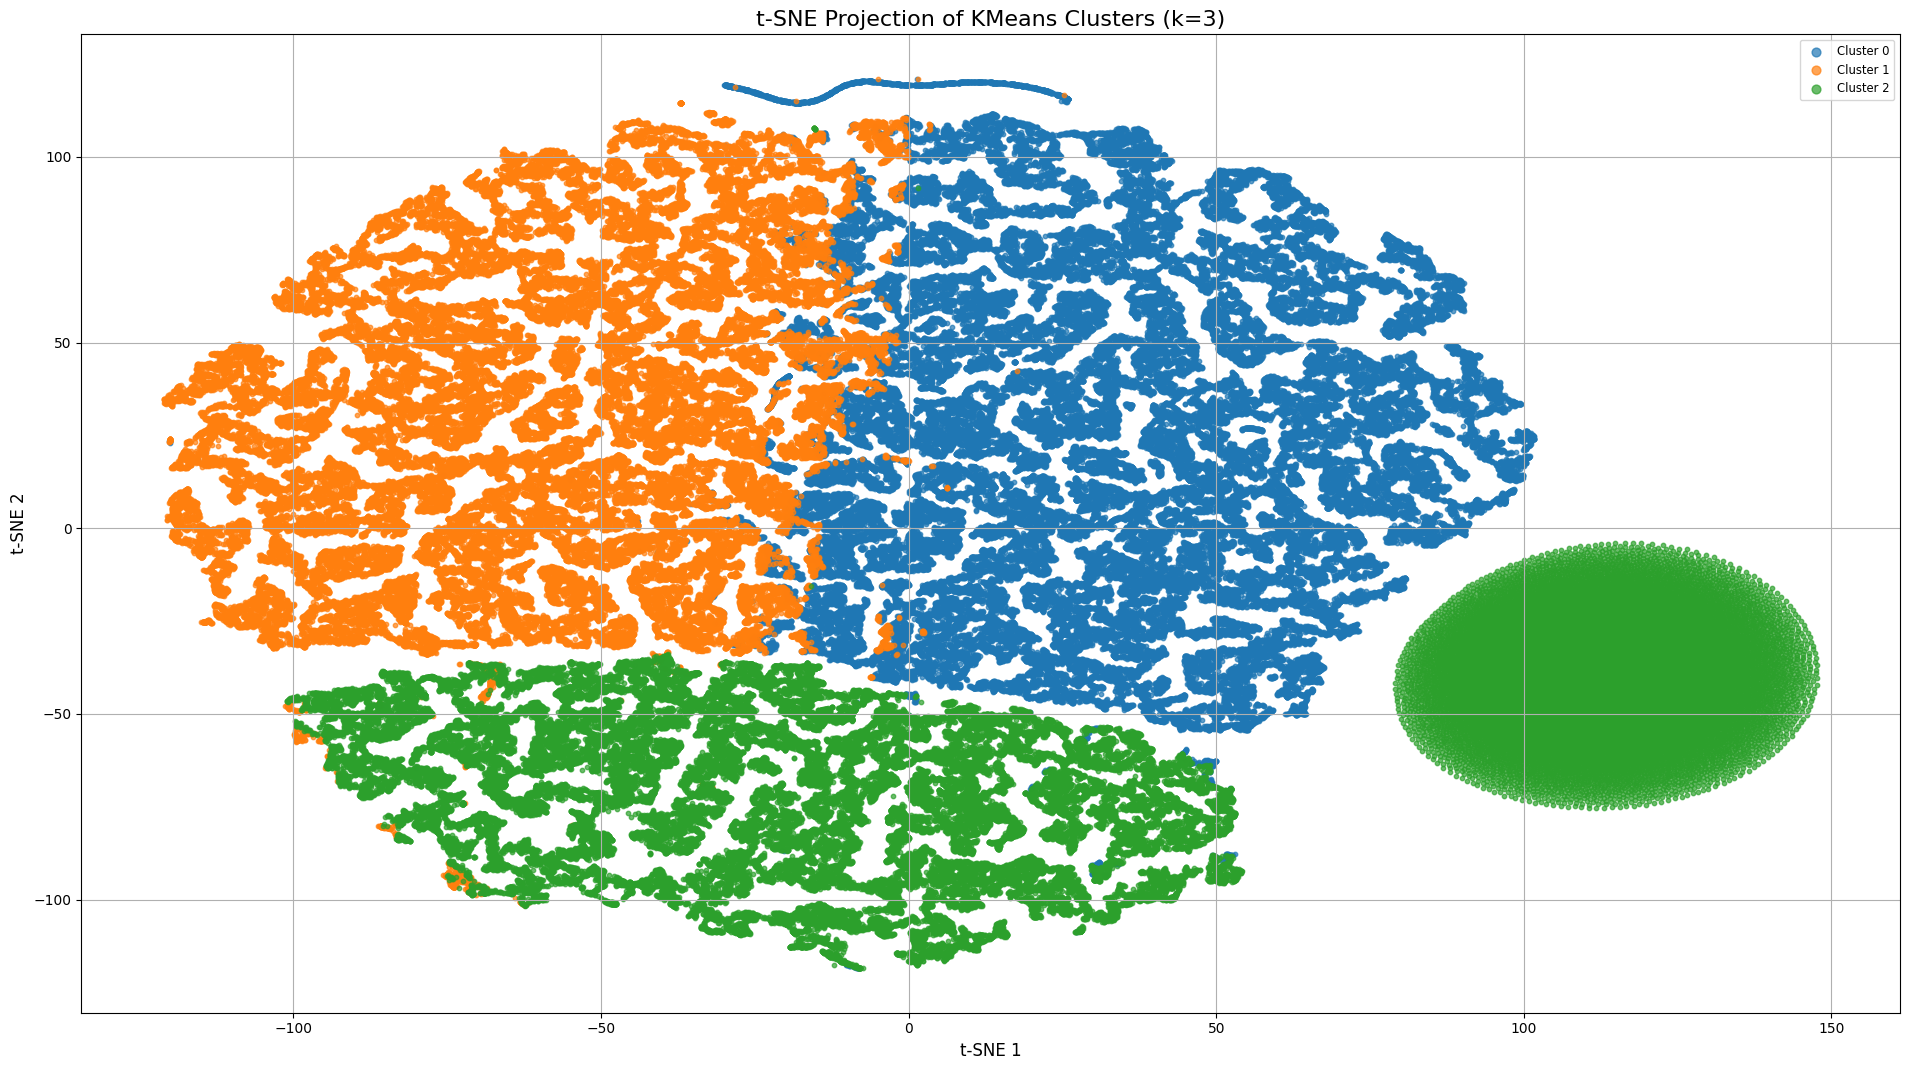

In [5]:
import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
from openTSNE import TSNE

# # Reduce dimensionality to 2D for visualization
# tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=200)
# X_embedded = tsne.fit_transform(X_scaled)
tsne = TSNE(
    n_components=2,
    perplexity=50,
    metric="cosine",
    n_jobs=8,  # number of threads
    random_state=42
)
X_embedded = tsne.fit(X_scaled)

# Add t-SNE coordinates to DataFrame for plotting
df["tsne_1"] = X_embedded[:, 0]
df["tsne_2"] = X_embedded[:, 1]

# Set figure size to match 1920x1080 pixels with dpi=100
fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100)

# Plot each cluster
for cluster_id in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == cluster_id]
    ax.scatter(subset["tsne_1"], subset["tsne_2"], s=10, label=f"Cluster {cluster_id}", alpha=0.7)

# Titles and labels
ax.set_title(f"t-SNE Projection of KMeans Clusters (k={optimal_k})", fontsize=16)
ax.set_xlabel("t-SNE 1", fontsize=12)
ax.set_ylabel("t-SNE 2", fontsize=12)
ax.legend(markerscale=2, fontsize="small", loc="best")
ax.grid(True)

# Save as Full HD PNG
plt.tight_layout()
# plt.savefig("tsne_clusters_fullhd.png", dpi=100)  # or dpi=200 for 4K
plt.show()



In [15]:
df_0 = df[df["cluster"] == 0]
df_1 = df[df["cluster"] == 1]
df_2 = df[df["cluster"] == 2]

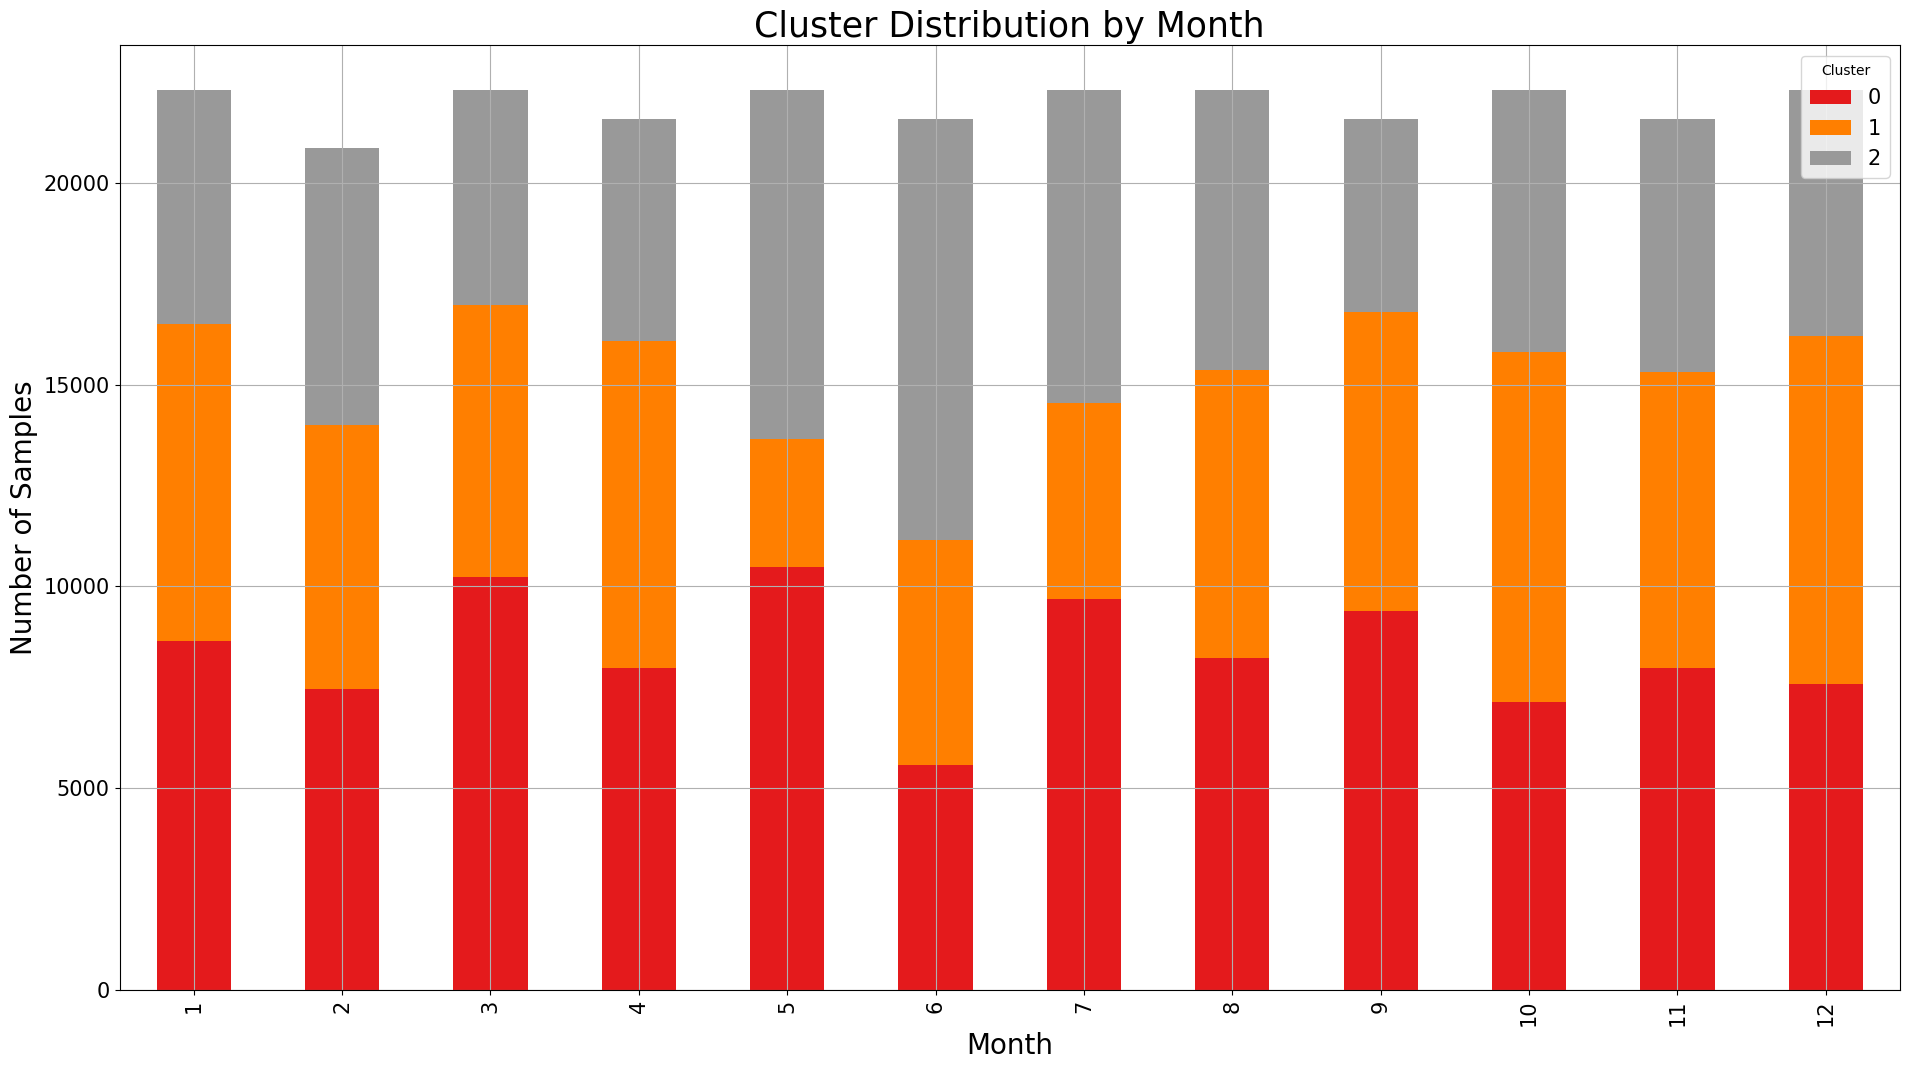

In [13]:
from datetime import datetime
import matplotlib.pyplot as plt

dates = []
for f in df['filename']:
    parts = f.replace('.npy', '').split('_')
    year, month, day, hour, minute, second = map(int, parts[1:])
    dates.append(datetime(year, month, day, hour, minute, second))

df['dates'] = dates

df['month'] = df['dates'].dt.month
monthly_counts = df.groupby(['month', 'cluster']).size().unstack(fill_value=0)

monthly_counts.plot(kind='bar', stacked=True, colormap='Set1', figsize=(19.2, 10.8))
plt.title("Cluster Distribution by Month", fontsize=25)
plt.xlabel("Month", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Number of Samples", fontsize=20)
plt.legend(title='Cluster', fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
df_2

,filename,float1,float2,float3,float4,cluster,tsne_1,tsne_2,dates,day_of_year,month
2,map_2024_1_1_9_6_0.npy,0.00,0.00,0.00,0.0,2,109.315497,-35.785003,2024-01-01 09:06:00,1,1
7,map_2024_1_1_9_4_0.npy,-3.09,0.05,-3.60,0.0,2,2.078489,-68.961659,2024-01-01 09:04:00,1,1
12,map_2024_1_1_9_2_0.npy,-3.30,0.17,-3.56,0.0,2,2.371100,-69.028609,2024-01-01 09:02:00,1,1
17,map_2024_1_1_9_0_0.npy,-3.33,0.45,-3.41,0.0,2,15.263016,-59.397889,2024-01-01 09:00:00,1,1
19,map_2024_1_1_22_44_0.npy,2.49,-8.94,3.04,0.0,2,-71.334209,-63.417214,2024-01-01 22:44:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...
262935,map_2024_12_31_16_44_0.npy,-4.90,6.97,-1.47,0.0,2,33.393752,-72.878547,2024-12-31 16:44:00,366,12
262992,map_2024_12_31_18_38_0.npy,0.00,0.00,0.00,0.0,2,118.255549,-16.708901,2024-12-31 18:38:00,366,12
262994,map_2024_12_31_18_42_0.npy,0.00,0.00,0.00,0.0,2,102.599004,-38.827269,2024-12-31 18:42:00,366,12
262995,map_2024_12_31_18_44_0.npy,0.00,0.00,0.00,0.0,2,85.408395,-43.378537,2024-12-31 18:44:00,366,12


In [22]:
# Assuming you have a DataFrame df with float1, float2, float3 and cluster
summary = df.groupby("cluster")[["float1", "float2", "float3", "float4"]].agg(["mean", "std", "min", "max"])

# Optional: flatten MultiIndex columns
summary.columns = ['_'.join(col) for col in summary.columns]

# Reset index for readability
summary = summary.reset_index()

# If you want long-format version for easier plotting:
long_summary = pd.melt(
    summary,
    id_vars="cluster",
    var_name="feature_stat",
    value_name="value"
)

# Split 'float1_mean' into 'feature' and 'stat'
long_summary[["feature", "stat"]] = long_summary["feature_stat"].str.extract(r"(float\d)_(\w+)")
long_summary = long_summary.drop(columns="feature_stat")

# Optional: pivot to have mean/std/min/max columns per feature per cluster
tidy = long_summary.pivot_table(index=["cluster", "feature"], columns="stat", values="value").reset_index()

# Pretty print
print(tidy)


stat  cluster feature    max        mean      min        std
0           0  float1  16.68   -2.898133   -42.79   2.914829
1           0  float2  69.76    3.193067   -30.92   4.004530
2           0  float3  46.97   -0.508335   -47.85   4.507955
3           0  float4   0.00 -395.511983  -950.90  84.652638
4           1  float1  24.14    2.886930   -22.48   3.097902
5           1  float2  16.54   -3.582094   -63.68   4.014870
6           1  float3  27.98    0.451503   -45.89   4.652522
7           1  float4   0.00 -397.894741 -1024.80  91.095489
8           2  float1  19.77   -0.210577   -21.26   3.263352
9           2  float2  35.70    0.179283   -27.89   3.349437
10          2  float3  52.51   -0.036267   -45.67   3.508416
11          2  float4   0.00    0.000000     0.00   0.000000


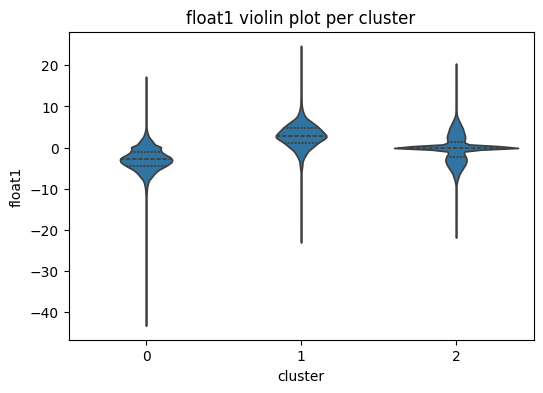

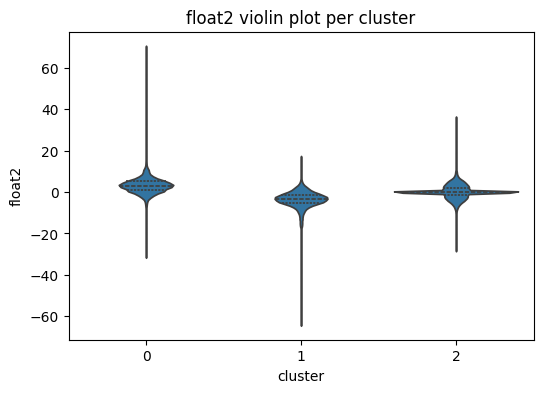

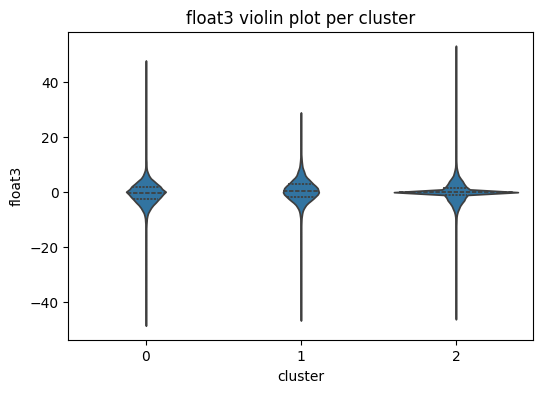

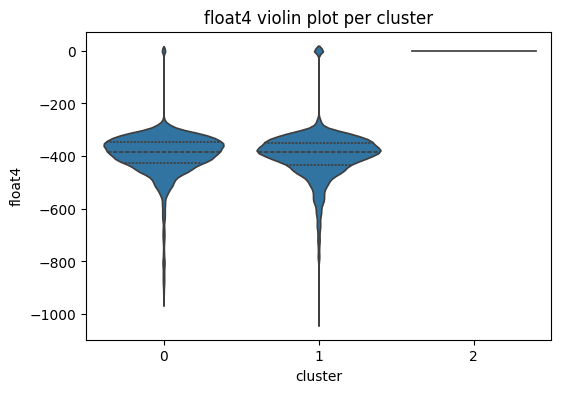

In [25]:
for col in ["float1", "float2", "float3", "float4"]:
    import seaborn as sns
    plt.figure(figsize=(6, 4))
    sns.violinplot(x="cluster", y=col, data=df, inner="quartile")
    plt.title(f"{col} violin plot per cluster")
    plt.show()


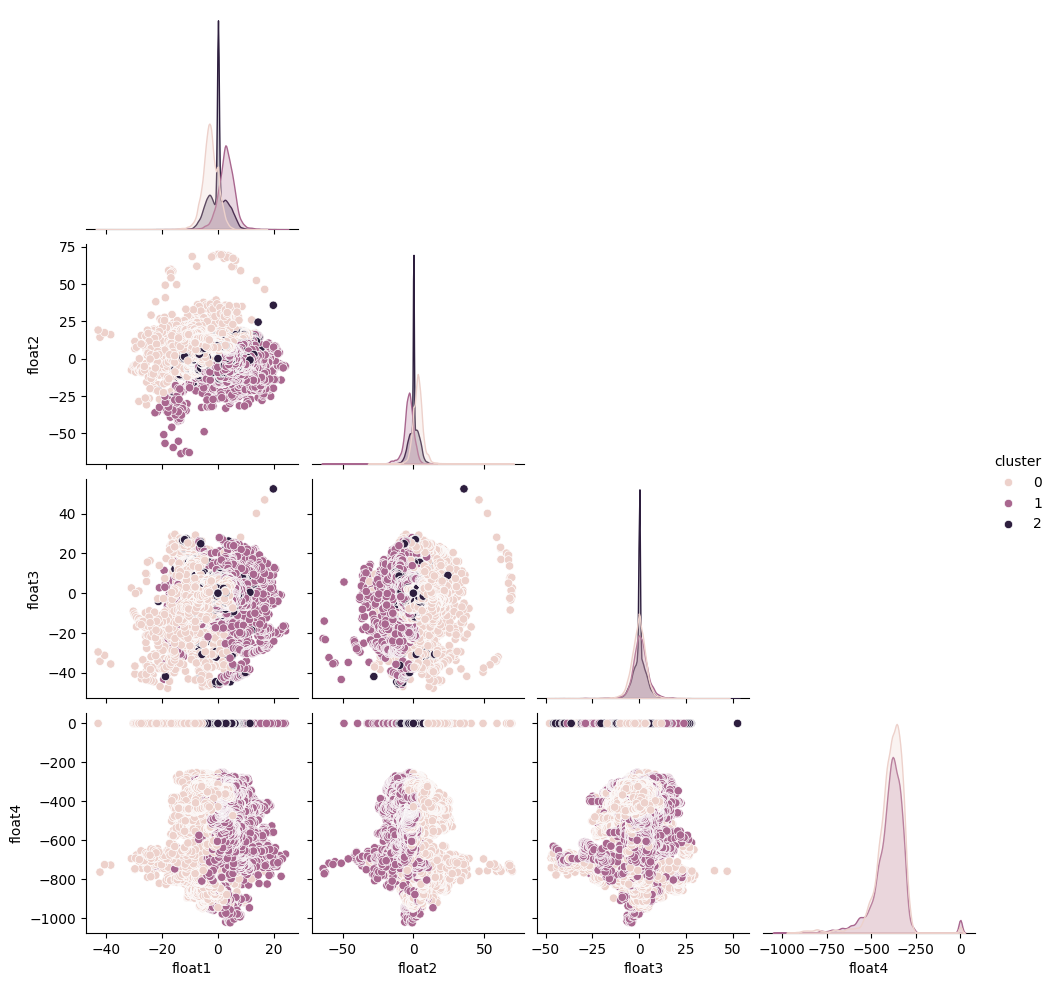

In [26]:
import seaborn as sns
sns.pairplot(df, vars=["float1", "float2", "float3", "float4"], hue="cluster", corner=True)


In [27]:
for cluster_id in [0, 1, 2]:
    corr = df[df["cluster"] == cluster_id][["float1", "float2", "float3", "float4"]].corr()
    print(f"\nCluster {cluster_id} Correlation:\n{corr}\n")



Cluster 0 Correlation:
          float1    float2    float3    float4
float1  1.000000  0.126748  0.045834  0.099070
float2  0.126748  1.000000  0.012672 -0.005869
float3  0.045834  0.012672  1.000000  0.000525
float4  0.099070 -0.005869  0.000525  1.000000


Cluster 1 Correlation:
          float1    float2    float3    float4
float1  1.000000  0.172554 -0.029322  0.017036
float2  0.172554  1.000000  0.063729 -0.022539
float3 -0.029322  0.063729  1.000000  0.025319
float4  0.017036 -0.022539  0.025319  1.000000


Cluster 2 Correlation:
          float1    float2    float3  float4
float1  1.000000 -0.297666  0.027786     NaN
float2 -0.297666  1.000000 -0.006104     NaN
float3  0.027786 -0.006104  1.000000     NaN
float4       NaN       NaN       NaN     NaN



<AxesSubplot: title={'center': 'Missing Data Frequency by Month'}, xlabel='month', ylabel='# of Missing Samples'>

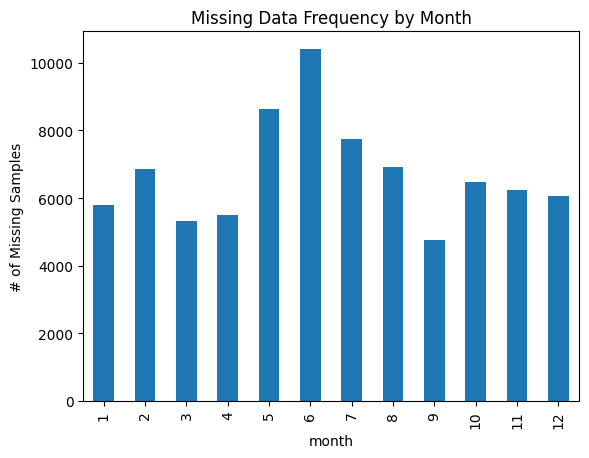

In [28]:
missing_by_month = df[df["cluster"] == 2].groupby("month").size()
missing_by_month.plot(kind="bar", title="Missing Data Frequency by Month", ylabel="# of Missing Samples")


/tmp/ipykernel_2005861/4067901441.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)


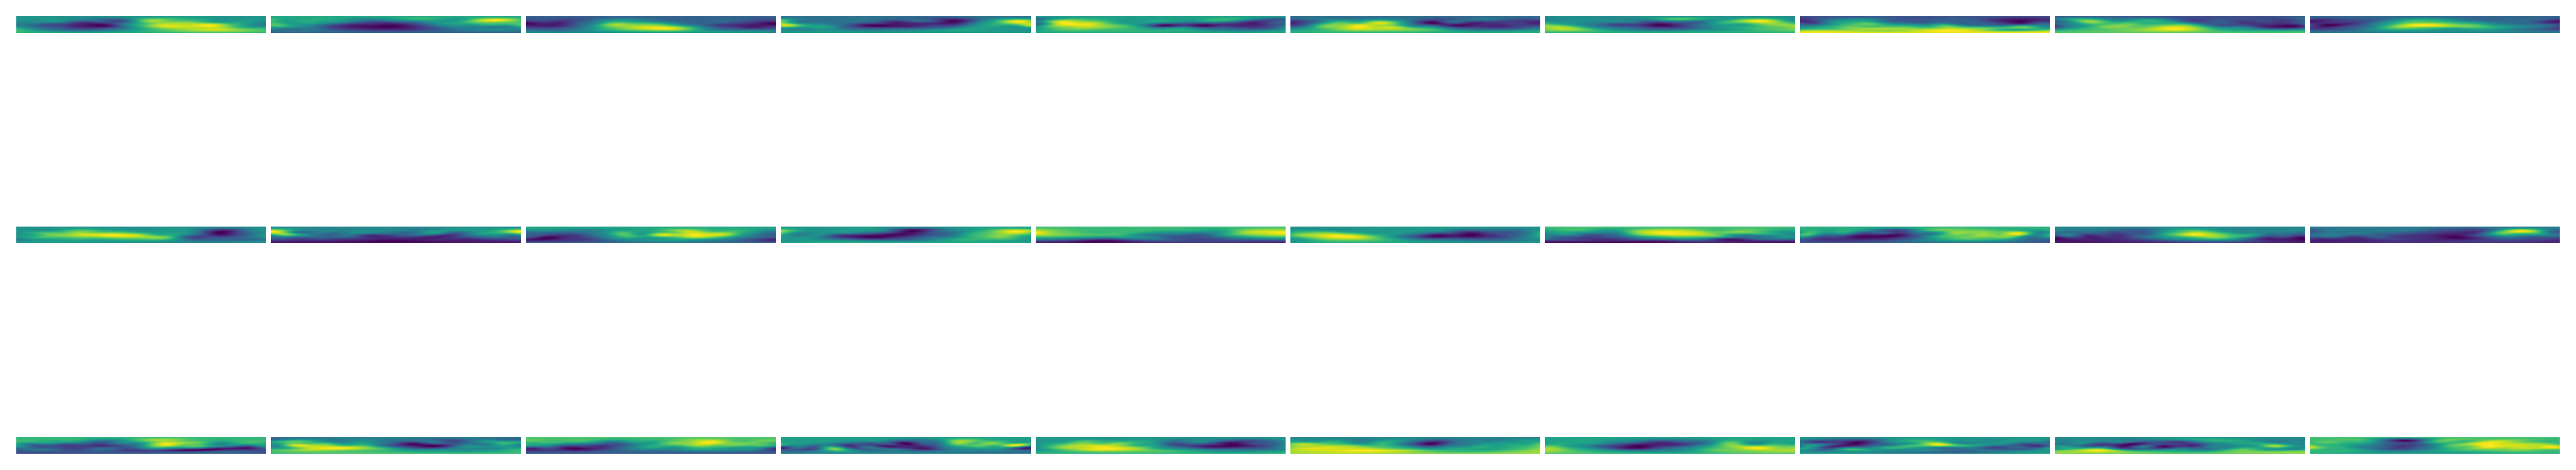

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameters
clusters = [0, 1, 2]
num_samples = 10
image_shape = (24, 360)
base_path = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/pickled_maps/"

# Create large grid: 3 rows x 10 columns
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5), 
                         gridspec_kw={'wspace': 0.02, 'hspace': 0.0001}, dpi=600)

for row_idx, cluster_id in enumerate(clusters):
    sample_df = df[df["cluster"] == cluster_id].sample(n=num_samples, random_state=42)
    
    for col_idx, (idx, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(base_path, row["filename"])
        ax = axes[row_idx, col_idx]

        try:
            img = np.load(img_path, allow_pickle=True)[0]
            if img.shape != image_shape:
                print(f"Skipping image with wrong shape: {img_path}")
                ax.axis("off")
                continue
        except Exception as e:
            print(f"Failed to load {img_path}: {e}")
            ax.axis("off")
            continue
        
        ax.imshow(img, cmap="viridis", aspect='equal')
        ax.axis("off")

        if col_idx == 0:
            ax.set_ylabel(f"Cluster {cluster_id}", fontsize=10)

plt.tight_layout(pad=0.0)
plt.show()

